<a href="https://colab.research.google.com/github/Saran-nns/incremental_learning_tf2.0/blob/master/incremental_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data pipe line

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

### Data

In [0]:
# Variable 'train_dataset' carries the shuffled dataset
# Split the dataset into tuple((train_images,train_labels),(test_images, test_labels)) 

dataset = datasets.cifar10.load_data()
# print('Shape of dataset',np.shape(dataset))
filtered_training_data = []
filtered_labels = []
allowed_labels = [0,1,2,3,4,5,6,7]
# print('Shape of training images',dataset[0][0].shape)

for i, _ in enumerate(dataset[0][0]):
  if dataset[0][1][i] in allowed_labels:
    filtered_training_data.append(dataset[0][0][i]/np.float32(255))
    filtered_labels.append(dataset[0][1][i])

"""NOTE: One liner: dataset = train_data.filter(lambda x,y: tf.reduce_all(tf.not_equal(y, [8,9]))).batch(200)"""

train_dataset = tf.data.Dataset.from_tensor_slices((filtered_training_data, filtered_labels))
train_dataset.shuffle(40000)

# Split into train and test
trainind_dataset_size = int(len(list(train_dataset))*0.8)
train_ds,test_ds = train_dataset.take(trainind_dataset_size), train_dataset.skip(trainind_dataset_size)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
class FeatureExtractor(Model):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.maxpool = MaxPooling2D((2,2))
    self.conv2 = Conv2D(64, 3, activation='relu')
    self.conv3 = Conv2D(64,3,activation='relu')
  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    return x

# Create an instance of the model
feature_extractor = FeatureExtractor()


In [0]:
class Classifier(Model):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(64, activation='relu')
    self.d2 = Dense(n_classes)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
classifier = Classifier(n_classes=5)

In [0]:
class IncrementalLearning(Model):

  def __init__(self, feature_extractor,classifier):
    super(IncrementalLearning, self).__init__()
    self.feature_extractor=feature_extractor
    self.classifier = classifier

  def call(self, x):
    features = self.feature_extractor(x)
    x = self.classifier(features)
    return x
model = IncrementalLearning(feature_extractor,classifier)

### Train Using custom tap gradient loss functions 

In [0]:
# Optimization criterion
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### With prebuild model compile and fit ops

##### Split the train and test datasets such that the model can be easily compiled by the predefined methods and can easily be compatibile with the mirroring. 

In [0]:
# Variable 'train_dataset' carries the shuffled dataset
# Split the dataset into tuple((train_images,train_labels),(test_images, test_labels)) 

dataset = datasets.cifar10.load_data()
print('Shape of dataset',np.shape(dataset))
filtered_training_data = []
filtered_labels = []
allowed_labels = [0,1,2,3,4,5,6,7]
print('Shape of training images',dataset[0][0].shape)

for i, _ in enumerate(dataset[0][0]):
  if dataset[0][1][i] in allowed_labels:
    filtered_training_data.append(dataset[0][0][i]/np.float32(255))
    filtered_labels.append(dataset[0][1][i])
train_dataset = tf.data.Dataset.from_tensor_slices((filtered_training_data, filtered_labels))
train_dataset.shuffle(40000)

# Split into train and test
trainind_dataset_size = int(len(list(train_dataset))*0.8)
train_ds,test_ds = train_dataset.take(trainind_dataset_size), train_dataset.skip(trainind_dataset_size)

Shape of dataset (2, 2)
Shape of training images (50000, 32, 32, 3)


In [0]:
train_images,train_labels= np.array(list(train_ds))[:,0],np.array(list(train_ds))[:,1]
train_images,train_labels = tf.convert_to_tensor(train_images.tolist()), tf.convert_to_tensor(train_labels.tolist())

test_images,test_labels = np.array(list(test_ds))[:,0],np.array(list(test_ds))[:,1]
test_images,test_labels = tf.convert_to_tensor(test_images.tolist()),tf.convert_to_tensor(test_labels.tolist())
print('Shape of training images after filtering labels',np.shape(train_images))

Shape of training images after filtering labels (32000, 32, 32, 3)


In [0]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [0]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

  feature_extractor = FeatureExtractor()
  classifier = Classifier(n_classes=8)
  model = IncrementalLearning(feature_extractor,classifier)

  # Compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  # Train the model
  history = model.fit(train_images, train_labels, epochs=10, 
                      validation_data=(test_images, test_labels),callbacks=[cp_callback])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/10
 987/1000 [============================>.] - ETA: 0s - loss: 1.4691 - accuracy: 0.4501
Epoch 00001: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 5s 5ms/step - loss: 1.4668 - accuracy: 0.4512 - val_loss: 1.2167 - val_accuracy: 0.5610
Epoch 2/10
 991/1000 [============================>.] - ETA: 0s - loss: 1.1605 - accuracy: 0.5797
Epoch 00002: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 4s 4ms/step - loss: 1.1606 - accuracy: 0.5799 - val_loss: 1.0880 - val_accuracy: 0.6055
Epoch 3/10
 998/1000 [============================>.] - ETA: 0s - loss: 1.0276 - accuracy: 0.6290
Epoch 00003: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 5s 5ms/step - loss: 1.0276 - accuracy: 0.6290 - val_loss: 1.0323 - val_accuracy: 0.6259
Epoch 4/10
 986/1000 [============================>.] - ETA: 

250/250 - 1s - loss: 0.8961 - accuracy: 0.6929


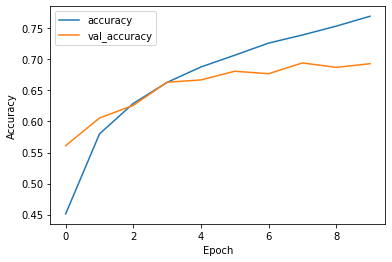

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

#### Instantiate new model and load weights from checkpoint

In [0]:
# Create a new model instance
model = IncrementalLearning(feature_extractor,classifier)
# Load the previously saved weights
model.load_weights('./training_1/cp.ckpt')

### Compile the loaded model  

In [0]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Wrapper for adding new data point with new label into the existing dataset

In [0]:
# Variable 'train_dataset' carries the shuffled dataset
# Split the dataset into tuple((train_images,train_labels),(test_images, test_labels)) 

dataset = datasets.cifar10.load_data()

def custom_dataset_loader(dataset = dataset, new_data = None, old_labels=[0,1,2,3,4,5,6,7], new_labels= [8,9]):
  
  filtered_training_data = []
  filtered_labels = []
  allowed_labels = old_labels + new_labels
  
  # Pick only the data with required labels
  for i, _ in enumerate(dataset[0][0]):
    if dataset[0][1][i] in allowed_labels:
      filtered_training_data.append(dataset[0][0][i]/np.float32(255))
      filtered_labels.append(dataset[0][1][i])

  train_dataset = tf.data.Dataset.from_tensor_slices((filtered_training_data, filtered_labels))
  # TODO: new_dataset = train_dataset+old_dataset
  train_dataset.shuffle(len(list(train_dataset)))

  # Split into train and test (80%, 20%)
  trainind_dataset_size = int(len(list(train_dataset))*0.8)
  train_ds,test_ds = train_dataset.take(trainind_dataset_size), train_dataset.skip(trainind_dataset_size)

  # Split the images and labels in train and test datasets
  train_images,train_labels= np.array(list(train_ds))[:,0],np.array(list(train_ds))[:,1]
  train_images,train_labels = tf.convert_to_tensor(train_images.tolist()), tf.convert_to_tensor(train_labels.tolist())
  test_images,test_labels = np.array(list(test_ds))[:,0],np.array(list(test_ds))[:,1]
  test_images,test_labels = tf.convert_to_tensor(test_images.tolist()),tf.convert_to_tensor(test_labels.tolist())
  print('Shape of training images after filtering labels',np.shape(train_images))

  return train_images,train_labels,test_images,test_labels

In [0]:
train_images,train_labels,test_images,test_labels = custom_dataset_loader(dataset = dataset, new_data = None, old_labels=[0,1,2,3,4,5,6,7], new_labels= [8,9])

Shape of training images after filtering labels (40000, 32, 32, 3)


### Wrapper to dynamically change the architecture of the model with respect to the number of classes in training data

In [0]:
class FeatureExtractor(Model):
  def __init__(self,trainable):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu',trainable = trainable)
    self.maxpool = MaxPooling2D((2,2))
    self.conv2 = Conv2D(64, 3, activation='relu',trainable = trainable)
    self.conv3 = Conv2D(64,3,activation='relu',trainable = trainable)
  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    return x

class Classifier(Model):
  def __init__(self, n_classes,trainable):
    super(Classifier, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(64, activation='relu',trainable = trainable)
    self.d2 = Dense(n_classes,trainable = True)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
class IncrementalLearning(Model):

  def __init__(self, feature_extractor,classifier):
    super(IncrementalLearning, self).__init__()
    self.feature_extractor=feature_extractor
    self.classifier = classifier

  def call(self, x):
    features = self.feature_extractor(x)
    x = self.classifier(features)
    return x

In [0]:
### 